In [27]:
%matplotlib inline
import numpy as np                                                                                                     
import pandas as pd                                                                                                    
import os                                                                                                              
from scipy import signal                                                                                               
from scipy.integrate import simps                                                                                      
from scipy import stats                                                                                                
import datetime                                                                                                        
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder                                                                         
from sklearn.model_selection import train_test_split                                                                   
from sklearn import svm                                                                                                
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score                                      
import sklearn.decomposition    
%matplotlib widget

In [2]:
# functions
def find_peak_freq_power(psd,freqs,low,high):                                                                          
    # find the peak frequency and power of a particular frequency band [low>= freq <= high]                            
    idx_band = np.logical_and(freqs >= low, freqs <= high)                                                             
    freq_band = freqs[idx_band]                                                                                        
    psd_band = psd[idx_band]                                                                                           
    ipeak_psd = np.where(psd_band>=np.max(psd_band))[0][0]                                                             
    peak_freq = freq_band[ipeak_psd]                                                                                   
    peak_psd = psd_band[ipeak_psd]                                                                                          
    return(peak_freq,peak_psd)                                                                                         
                                                                                                                       
def compute_band_power(Sxx,freqs,bands):                                                                               
    # Sxx: a matrix of power spectrogram per time [nfreqs,ntimebins]                                                   
    # bands: a list containing the range for each frequency band                                                       
    # fregs: list of frequencies                                                                                       
    abspower = np.zeros((Sxx.shape[1],len(bands)))                                                                     
    for i in np.arange(0,Sxx.shape[1]):                                                                                
        for j in np.arange(0,len(bands)):                                                                              
            low = bands[j][0]                                                                                          
            high = bands[j][1]                                                                                         
            idx_range = np.logical_and(freqs >= low, freqs <= high)                                                    
            abspower[i,j] = simps(Sxx[idx_range,i],dx = freqs[1]-freqs[0])                                             
    return(abspower)

def compute_1samp_t_test_of_across_time(power):                                                                        
    # compute t_test across time for each frequency band                                                               
    means = np.zeros((power.shape[1]))                                                                                 
    stds = np.zeros((power.shape[1]))                                                                                  
    pvalues = np.zeros((power.shape[1]))                                                                               
                                                                                                                       
    for i in np.arange(0,power.shape[1]):                                                                              
        means[i] = power[:,i].mean()                                                                                   
        stds[i] = power[:,i].std()                                                                                     
        tvalue,pvalues[i] = stats.ttest_1samp(power[:,i],means[i])                                                     
                                                                                                                       
    return(pvalues)   

def compute_statistics(power):                                                                                         
    # compute t_test across time for each frequency band                                                               
    means = np.zeros((power.shape[1]))                                                                                 
    stds = np.zeros((power.shape[1]))                                                                                  
                                                                                                                       
    for i in np.arange(0,power.shape[1]):                                                                              
        means[i] = power[:,i].mean()                                                                                   
        stds[i] = power[:,i].std()                                                                                     
                                                                                                                       
    return(means,stds)                                                                                                 
                                                                                                                       
def compute_t_test_bw_groups_across_time(power1,power2):                                                               
    # compute t_test between groups for each frequency band                                                            
    pvalues = np.zeros((power1.shape[1]))                                                                              
    for i in np.arange(0,power1.shape[1]):                                                                             
        tvalue,pvalues[i] = stats.ttest_ind(power1[:,i],power2[:,i],equal_var=False)                                   
    return(pvalues) 

def butter_bandpass(lowcut, highcut, fs, order=5):                                                                     
    nyq = 0.5 * fs                                                                                                     
    low = lowcut / nyq                                                                                                 
    high = highcut / nyq                                                                                               
    b, a = signal.butter(order, [low, high], btype='band')                                                             
    return b, a                                                                                                        
                                                                                                                       
                                                                                                                       
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):                                                        
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)                                                           
    y = signal.lfilter(b, a, data)                                                                                     
    return y   

In [3]:
datapath = "/home/anup/goofy/data/ml/neurovine/"                                                  
aa_name = "AA_EEG_data.csv"                                                                                            
bb_name = "BB_EEG_data.csv"                                                                                            
adata = pd.read_csv(os.path.join(datapath,aa_name))                                                                    
bdata = pd.read_csv(os.path.join(datapath,bb_name))                                                                    
channels = ["AF7","FPz","AF8"]                                                                                         
channel = channels[2]                                                                                                  
# create time axis                                                                                                     
si = 1/200                                                                                                             
adata["t"] = np.arange(0,(len(adata))*si,si)                                                                           
bdata["t"] = np.arange(0,(len(bdata))*si,si)                                                                   

In [4]:
# skip the initial 5 sec 
t0 = 5                                                                                                                 
fs = 200                                                                                                               
lowcut = 0.8                                                                                                           
highcut = 40                                                                                                           
                                                                                                                       
ay = adata[channel]                                                                                                    
by = bdata[channel]                                                                                                    
ayf = butter_bandpass_filter(ay,lowcut,highcut,fs)                                                                     
byf = butter_bandpass_filter(by,lowcut,highcut,fs)                                                                     
ayf2 = ayf[adata["t"]>t0]                                                                                              
byf2 = byf[bdata["t"]>t0]

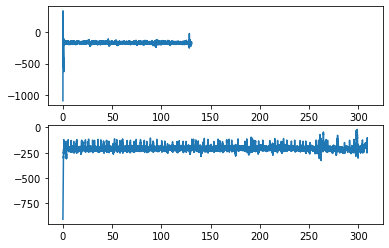

In [5]:
# plot filtered data
fh = plt.figure()                                                                                                      
ah1 = fh.add_subplot(211) 

ah1.plot(adata["t"],adata[channel])                                                                               
ah2 = fh.add_subplot(212,sharex=ah1)                                                                                   
ah2.plot(bdata["t"],bdata[channel]) 

#ah1.plot(adata["t"][adata["t"]>t0],ayf2)                                                                               
#ah2 = fh.add_subplot(212,sharex=ah1)                                                                                   
#ah2.plot(bdata["t"][bdata["t"]>t0],byf2)      

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
(30, 2)


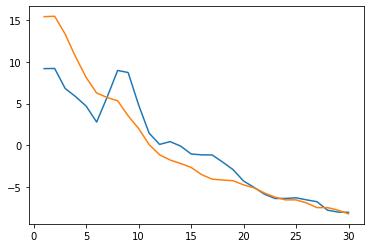

In [6]:
# compute PSDs for channel "AF8"
freqs,a_psd = signal.welch(ayf2,fs=200,nperseg=200,noverlap=100,nfft=200,detrend=False,return_onesided=True)  
# print(freqs)
freqs,b_psd = signal.welch(byf2,fs=200,nperseg=200,noverlap=100,nfft=200,detrend=False,return_onesided=True) 
# print(freqs)
# crop to the required frequency bands
a_psd = a_psd[(freqs>=1) & (freqs <=30)]                                                                               
b_psd = b_psd[(freqs>=1) & (freqs <=30)]                                                                               
freqs = freqs[(freqs>=1) & (freqs <=30)]                                                                               
psds = np.concatenate((a_psd[:,None],b_psd[:,None]),axis=1) 
print(freqs)
print(psds.shape)
plt.plot(freqs,np.log10(psds)*10)

In [7]:
# define features: frequency band                                                                                       
delta_range = [0.5,4]                                                                                                    
theta_range = [4,7]                                                                                                    
alpha_range = [8,12]                                                                                                   
beta_range = [13,30] 
sigma_range = [12,16]
full_range = [1,30]                                                                                                    
all_ranges = [delta_range,theta_range,alpha_range,beta_range,full_range] 

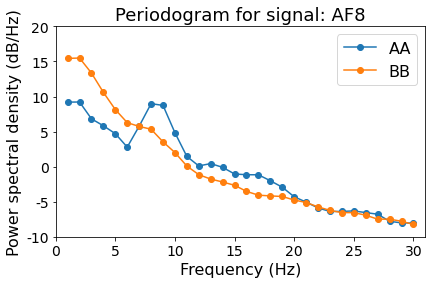

In [8]:
# plot PSD of AA and BB signal for electrode "AF8"
fh2 = plt.figure()                                                                                                      
ah1 = fh2.add_subplot(111)                                                                                              
ah1.plot(freqs,np.log10(psds[:,0])*10,'-o')                                                                            
# ah1.plot(afreqs,np.log10(aSxx.mean(axis=-1))/10,'-')                                                                 
ah1.plot(freqs,np.log10(psds[:,1])*10,'-o')                                                                            
ah1.set_xlabel("Frequency (Hz)",fontsize=16)                                                                           
# ah1.set_ylabel("Power spectral density ($\mu$V$^2$/Hz)",fontsize=16)                                                 
ah1.set_ylabel("Power spectral density (dB/Hz)",fontsize=16)                                                           
ah1.set_title("".join(("Periodogram for signal: ",channel)),fontsize = 18)      
plt.tight_layout()                                                                                                     
ah1.legend(["AA","BB"],fontsize=16)  
ah1.set_xlim([0,31])                                                                                                   
xticks = [0,5,10,15,20,25,30]                                                                                          
ah1.set_xticks(xticks)                                                                                                 
ah1.set_xticklabels(xticks,fontsize=14)                                                                                
ah1.set_ylim([-10,20])                                                                                                 
yticks = [-10,-5,0,5,10,15,20]                                                                                         
ah1.set_yticks(yticks)                                                                                                 
ah1.set_yticklabels(yticks,fontsize=14) 
# save figure as png                                                                                                   
fname_fig_psd = "neurovine_plot_psd_aa_bb.png"                                                                         
fh2.savefig(os.path.join(datapath,fname_fig_psd),dpi=300)                                                              
plt.show() 

In [9]:
# find alpha peak frequency and PSD value for AA and BB                                                                
a_alpha_peak_freq, a_alpha_peak_psd = find_peak_freq_power(a_psd,freqs,alpha_range[0],alpha_range[1]) 
b_alpha_peak_freq, b_alpha_peak_psd = find_peak_freq_power(b_psd,freqs,alpha_range[0],alpha_range[1]) 
print("Channel AA -  Alpha peak frequency: {}, PSD: {} dB".format (a_alpha_peak_freq,np.log10(a_alpha_peak_psd)*10))     
print("Channel BB -  Alpha peak frequency: {}, PSD: {} dB".format (b_alpha_peak_freq,np.log10(b_alpha_peak_psd)*10))      

Channel AA -  Alpha peak frequency: 8.0, PSD: 8.983730470905602 dB
Channel BB -  Alpha peak frequency: 8.0, PSD: 5.341463326265721 dB


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.] [  0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.
   6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.
  12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.
  18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.
  24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.
  30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5  36.
  36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5

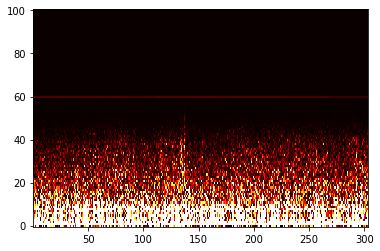

In [19]:
# compute PSDs for overlapping 1 sec windows                                                                                                                      
afreqs,at,aSxx = signal.spectrogram(ayf2,fs=200,nperseg=200,noverlap=100,nfft=200,detrend=False,return_onesided=True)  
bfreqs,bt,bSxx = signal.spectrogram(byf2,fs=200,nperseg=200,noverlap=50,nfft=200,detrend=False,return_onesided=True) 
Sxx = [aSxx,bSxx]  
print(afreqs,at)
plt.pcolormesh(bt, bfreqs, bSxx, shading='nearest',vmin=0,vmax=1,cmap="hot")
a_abspower = compute_band_power(aSxx,afreqs,all_ranges)                                                                
b_abspower = compute_band_power(bSxx,bfreqs,all_ranges)  
# compute statistics and t_tests
a_avgs,a_stds = compute_statistics(a_abspower)                                                                         
b_avgs,b_stds = compute_statistics(b_abspower)   
# compute t-tests                                                                                                      
p_values = compute_t_test_bw_groups_across_time(a_abspower,b_abspower)    

In [20]:
# create dataframe for statistics computed for signal "AF8"                                                                                                 
labels = np.repeat(["AA","BB"],len(all_ranges))                                                                        
features = np.tile(["delta","theta","alpha","beta","total"],2)                                                         
avgs = np.concatenate((a_avgs,b_avgs))                                                                                 
stds = np.concatenate((a_stds,b_stds))                                                                                 
pvals = np.concatenate((p_values,np.zeros(len(all_ranges))))                                                           
sigs = np.concatenate((p_values<0.05,np.zeros(len(all_ranges))))                                                       
data = {"cat":labels,"feature":features,"avg":avgs,"std":stds,"pval":pvals,"sig":sigs}                                    
df = pd.DataFrame(data) 
print("Spreadsheet of results for signal AF8\n")
print(df) 
# save the results into a spread sheet                                                                                 
fname_excelsheet = "neurovine_results_statistics_t_test_af8.xlsx"                                                      
df.to_excel(os.path.join(datapath,fname_excelsheet),sheet_name="AF8")    

Spreadsheet of results for signal AF8

  cat feature         avg         std          pval  sig
0  AA   delta   17.075423   87.521457  3.545387e-14  1.0
1  AA   theta    9.919712   33.335122  5.457440e-04  1.0
2  AA   alpha   17.057759   11.973578  1.407058e-25  1.0
3  AA    beta    7.576340    3.807961  3.036447e-14  1.0
4  AA   total   58.272205  120.898796  1.540629e-07  1.0
5  BB   delta   80.899350  121.882760  0.000000e+00  0.0
6  BB   theta   18.743711   27.972735  0.000000e+00  0.0
7  BB   alpha    6.772023   10.677020  0.000000e+00  0.0
8  BB    beta    5.403856    2.647648  0.000000e+00  0.0
9  BB   total  116.074238  154.978334  0.000000e+00  0.0


In [21]:
# create dataframe for machine learning   
tmax = 30
data = np.concatenate((a_abspower[at<=tmax,:],b_abspower[bt<=tmax,:]),axis=0)                                              
labels = np.concatenate((np.repeat("AA",len(at[at<=tmax])),np.repeat("BB",len(bt[bt<=tmax]))),axis=0)                      
df = pd.DataFrame({"cat":labels,"delta":data[:,0],"theta":data[:,1],"alpha":data[:,2],"beta":data[:,3],"total":data[:,\
-1]})  
print("len AA: {}".format(len(df[df["cat"]=="AA"])))
print("len BB: {}".format(len(df[df["cat"]=="BB"])))
#                                                                                                                      
# print(df.head())                                                                                                     
# convert categorical string lables to numbers                                                                         
le = LabelEncoder()                                                                                                    
df['labels'] = le.fit_transform(df['cat'])                                                                             
#X = df[["delta","theta","alpha","beta","total"]].to_numpy()                                                          
X = df[["delta","beta"]].to_numpy()                                                                                   
# X = df[["theta","alpha"]].to_numpy()                                                                                 
# X = df[["delta","theta","alpha","beta"]].to_numpy()                                                                  
y = df["labels"].to_numpy()                                                                                            
# data normalization: mean = 0 & std = 1                                                                               
X = (X - X.mean(axis=0))/X.std(axis=0)                                                                                 
print("Mean: {}, std: {}".format(X.mean(axis=0),X.std(axis=0))) 

len AA: 60
len BB: 40
Mean: [7.21644966e-17 1.66533454e-16], std: [1. 1.]


In [22]:
# dimensionality reduction  
X = df[["delta","theta","alpha","beta"]].to_numpy()           
pca = sklearn.decomposition.PCA().fit(X)                                                                               
print(pca.transform(X).shape)                                                                                          
print(pca.explained_variance_)                                                                                         
print(pca.explained_variance_ratio_)                                                                                   
X = pca.transform(X)[:,:2]      # select the first two components  

(100, 4)
[7.89813772e+03 1.84189180e+02 1.14972623e+02 4.75014810e+00]
[9.62946829e-01 2.24564819e-02 1.40175478e-02 5.79141592e-04]


In [23]:
# split data into test and training                                                                                    
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)                                                    
print(X_train.shape,y_train.shape) 
print(X_test.shape,y_test.shape) 

(80, 2) (80,)
(20, 2) (20,)


In [24]:
# fit using SVC from sklearn.svm class                                                                                 
svc = svm.SVC(kernel='linear', C=1).fit(X, y)                                                                          
#svc = svm.SVC(kernel='logistic', C=1).fit(X, y)                                                                      
#svc = svm.SVC(kernel='poly', degree=3, C=1)                                                                          
#svc = svm.SVC(kernel='rbf', gamma=0.7, C=1) # Gaussian kernel                                                        
# svc = svm.LinearSVC(C=C)                                                                                             
svc.fit(X_train,y_train)                                                                                               
y_pred = svc.predict(X_test) 
print(len(y_pred))

20


In [25]:
# Evaluate the model performance
print("Classification accuracy: {}".format(accuracy_score(y_test,y_pred)))                                             
print("Confusion matrix \n {}".format(confusion_matrix(y_test,y_pred)))                                                
print("Classification report \n {}".format(classification_report(y_test,y_pred))) 
CM = confusion_matrix(y_test,y_pred)
print("Accuracy: ",CM.diagonal().sum()/CM.ravel().sum())
print("precision : ",CM[0,0]/CM[:,0].sum())
print("Recall : ",CM[0,0]/CM[0,:].sum())

Classification accuracy: 0.85
Confusion matrix 
 [[12  0]
 [ 3  5]]
Classification report 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.62      0.77         8

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20

Accuracy:  0.85
precision :  0.8
Recall :  1.0


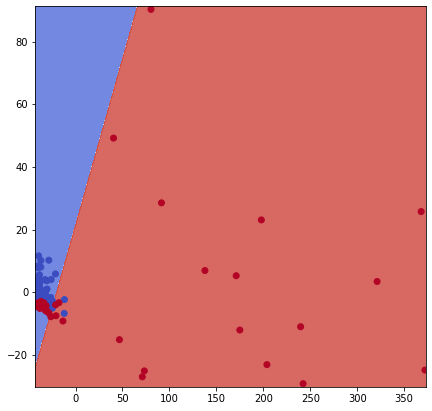

In [34]:
# create a mesh to plot                                                                                             
h = 0.2                        # step size in mesh  
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1                                                                    
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1                                                                    
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))    
Z = svc.predict(np.concatenate((xx.ravel()[:,None],yy.ravel()[:,None]),axis=1)) 
plt.close('all')
fh = plt.figure(figsize=(7,7))                                                                                                    
ah = fh.add_subplot(111) 
ah.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.8)                                             
ah.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)                                                               
#plt.show() 

In [ ]:
# correlation analysis between eeg features within groups
aa_corrmat = df[df["cat"]=="AA"].loc[:,"delta":"beta"].corr()  
bb_corrmat = df[df["cat"]=="BB"].loc[:,"delta":"beta"].corr()                                                                                   
print(np.tril(aa_corrmat))
print(np.tril(bb_corrmat))
# visualize correlations using a hearmap  
f, (ah1, ah2) = plt.subplots(1,2)
sns.heatmap(aa_corrmat,vmin=-1,vmax=1,center=0.5,cmap = "hot",square=True,ax=ah1) 
sns.heatmap(bb_corrmat,vmin=-1,vmax=1,center=0.5,cmap = "hot",square=True,ax=ah2) 
#ah1.invert_xaxis()
#ah2.invert_xaxis()
ah1.set_title("AA")
ah2.set_title("BB")
#ah=fh.add_subplot(122)
#sns.heatmap(bb_corrmat,vmin=-1,vmax=1,center=0.5,cmap = "hot",square=True,ax=ah)
#plt.show()   
# print(corrmat)                  

In [ ]:
# correlation analysis of eeg features between groups
adf = df[df["cat"]=="AA"][["delta","theta","alpha","beta"]].reset_index(drop=True)
bdf = df.loc[df["cat"]=="BB"][["delta","theta","alpha","beta"]].reset_index(drop=True)
print(adf[0:5])
print(len(adf),len(bdf))
print(bdf[0:5])
#print(adf[:100].corrwith(bdf[:100],axis=0))
ab_corrmat = adf.corrwith(bdf,axis=0)
print(ab_corrmat)